In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("data/aptos2019/train.csv")

# Step 1: Split off test set (20%)
train_val_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["diagnosis"], random_state=42
)

# Step 2: Split train_val into train (70%) and val (10%)
# Since test is 20%, we need 10% of total = 10 / 80 = 12.5% of train_val for val
train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df["diagnosis"], random_state=42
)


# Confirm distribution
print("Train:", train_df["diagnosis"].value_counts(normalize=True))
print("Val:", val_df["diagnosis"].value_counts(normalize=True))
print("Test:", test_df["diagnosis"].value_counts(normalize=True))


Train: diagnosis
0    0.492974
2    0.272834
1    0.101093
4    0.080406
3    0.052693
Name: proportion, dtype: float64
Val: diagnosis
0    0.493188
2    0.272480
1    0.100817
4    0.081744
3    0.051771
Name: proportion, dtype: float64
Test: diagnosis
0    0.492497
2    0.272851
1    0.100955
4    0.080491
3    0.053206
Name: proportion, dtype: float64


In [15]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['id_code']
        label = self.data.iloc[idx]['diagnosis']
        img_path = os.path.join(self.image_dir, img_id + '.png')
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label
    
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_dataset = DiabeticRetinopathyDataset(train_df, 'data/aptos2019/train_images', transform=train_transforms)
val_dataset = DiabeticRetinopathyDataset(val_df, 'data/aptos2019/train_images', transform=val_test_transforms)
test_dataset = DiabeticRetinopathyDataset(test_df, 'data/aptos2019/train_images', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [16]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import SwinForImageClassification

# Load pretrained DenseNet-121
densenet = models.densenet121(pretrained=True)

# Remove the classifier head
densenet_backbone = densenet.features

# Load pretrained Swin Transformer
swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Modify the input layer to accept DenseNet-121 features
swin_model.classifier = nn.Linear(in_features=1024, out_features=5)  # Assuming 5 DR severity levels



In [17]:
class HybridModel(nn.Module):
    def __init__(self, densenet_backbone, swin_model):
        super(HybridModel, self).__init__()
        self.densenet = densenet_backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling to match Swin input shape
        self.swin = swin_model

    def forward(self, x):
        x = self.densenet(x)  # Extract features using DenseNet-121
        x = self.pool(x).flatten(1)  # Pool and flatten for Swin Transformer
        x = self.swin.classifier(x)  # Final classification
        return x

# Initialize the hybrid model
model = HybridModel(densenet_backbone, swin_model)


In [ ]:
# @torch.no_grad()
# def evaluate(model, dataloader):
#     model.eval()
#     correct = 0
#     total = 0
#     running_loss = 0.0

#     for images, labels in dataloader:
#         images, labels = images.to(device), labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         running_loss += loss.item()
#         _, preds = torch.max(outputs, 1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     accuracy = correct / total
#     avg_loss = running_loss / len(dataloader)

#     return accuracy

In [22]:
import torch
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1  # or whatever you want

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

torch.save(model.state_dict(), 'best_model.pth')



Epoch 1/1
------------------------------


100%|██████████| 81/81 [08:19<00:00,  6.16s/it]


Train Loss: 0.0601 | Train Acc: 0.9789
Val Loss: 0.8888 | Val Acc: 0.8529


In [23]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on Test Set
# test_acc = evaluate(model, test_loader)
correct = 0
total = 0
running_loss = 0.0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

accuracy = correct / total
avg_loss = running_loss / len(test_loader)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8104


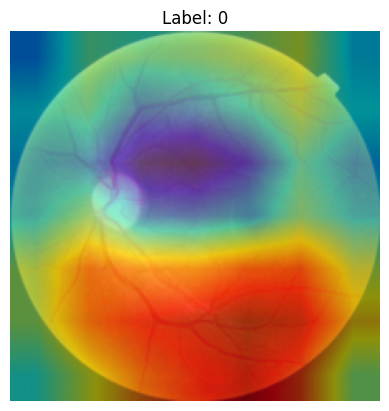

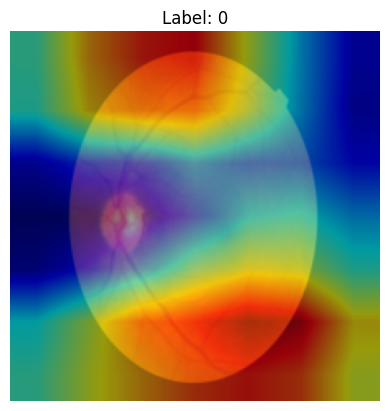

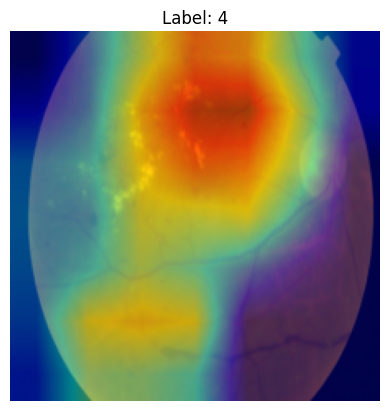

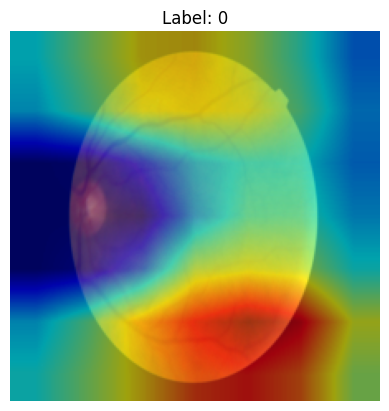

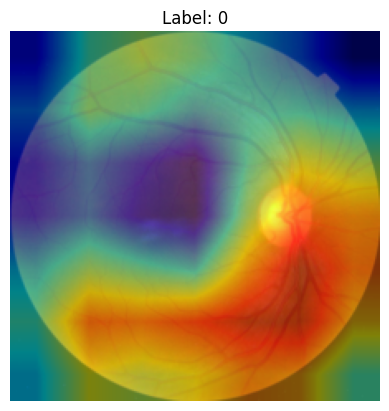

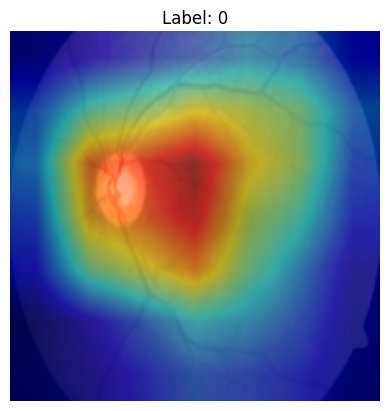

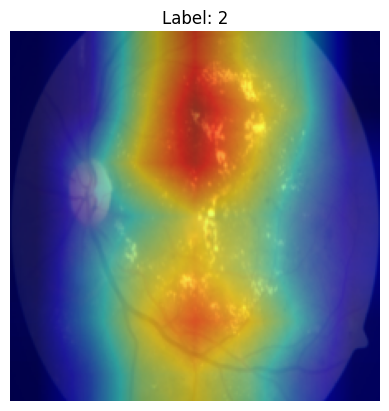

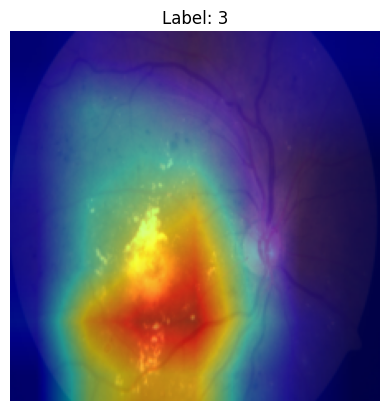

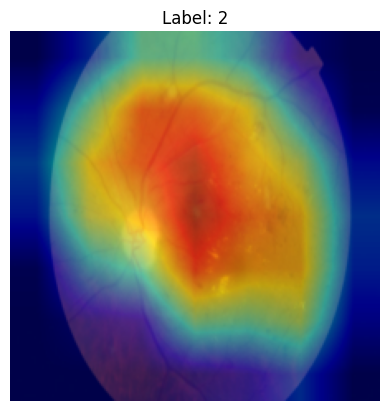

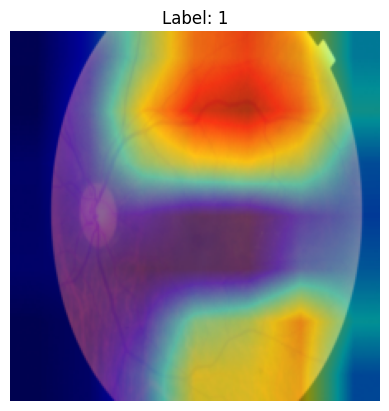

In [36]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pick target layer (last conv layer of DenseNet121 backbone)
target_layer = model.densenet[-1]   # update to your architecture

# Create GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Loop through the first 10 images from the test dataset
for i in range(10):
    # Get image and label from the test dataset
    input_tensor, label = test_dataset[i]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate CAM for the current image
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Convert the image tensor to numpy array and normalize
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Apply GradCAM to the image
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Visualize the image with the GradCAM overlay and label
    plt.imshow(cam_image)
    plt.title(f"Label: {label.item()}")  # Show label as the title
    plt.axis('off')  # Turn off axes
    plt.show()


In [31]:
print(model.densenet) 


Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke